In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# LOCAL
PROJECT_PATH = '/Users/ivan_zorin/Documents/DEV/code/ntl/'
DATA_PATH = '/Users/ivan_zorin/Documents/DEV/data/sgcc/data.csv'
LOG_DIR = '/Users/ivan_zorin/Documents/DEV/runs/debug/trainer'

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

import sys
sys.path.append(PROJECT_PATH)

from ntl.data import SGCCDataset
from ntl.data.transforms import FillNA, Scale, Diff, Cutout

In [53]:
transforms = [
    FillNA('drift'), 
    # Cutout(256), 
    Scale('minmax'), 
    # Diff(1)
]

normal_dataset = SGCCDataset(DATA_PATH, label=0, nan_ratio=0.75, transforms=transforms, year=2016)

anomal_dataset = SGCCDataset(DATA_PATH, label=1, nan_ratio=1.0, transforms=transforms, year=2016)

In [65]:
normal_data = normal_dataset.data
for tr in transforms:
    normal_data = tr(normal_data)
    
labels = np.zeros(normal_data.shape[0])
N = normal_data.shape[0]
print(N)


38701


In [66]:
anomal_data = anomal_dataset.data
for tr in transforms:
    anomal_data = tr(anomal_data)

anomal_labels = np.ones(anomal_data.shape[0])
M = anomal_data.shape[0]
print(M)

3580


In [67]:
all_data = np.concatenate([normal_data, anomal_data], axis=0)
all_labels = np.concatenate([labels, anomal_labels], axis=0)
NM = all_data.shape[0]
print(N + M == NM)

True


In [112]:
def decompose(method, data, **kwargs):
    data = method.fit_transform(data)
    return data

### tSNE of scaled data

In [69]:
tsne = TSNE(2)
all_data_tsne = tsne.fit_transform(all_data)

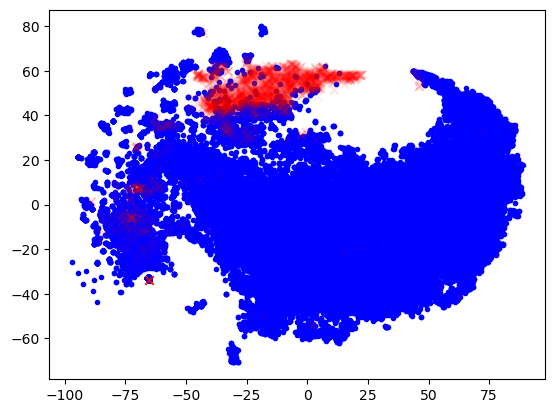

In [99]:
plt.figure()
plt.scatter(all_data_tsne[:N, 0], all_data_tsne[:N, 1], color='b', marker='.')
plt.scatter(all_data_tsne[N:, 0], all_data_tsne[N:, 1], color='r', marker='x', label='anomal', alpha=0.05)

plt.show()

### tSNE of lagged data

In [327]:
transforms = [
    FillNA('drift'), 
    # Cutout(256), 
    Scale('minmax'), 
    Diff(1)
]

normal_dataset = SGCCDataset(DATA_PATH, label=0, nan_ratio=0.75, transforms=transforms, year=2016)

anomal_dataset = SGCCDataset(DATA_PATH, label=1, nan_ratio=1.0, transforms=transforms, year=2016)

normal_data = normal_dataset.data
for tr in transforms:
    normal_data = tr(normal_data)
    
labels = np.zeros(normal_data.shape[0])
N = normal_data.shape[0]
print(N)

anomal_data = anomal_dataset.data
for tr in transforms:
    anomal_data = tr(anomal_data)

anomal_labels = np.ones(anomal_data.shape[0])
M = anomal_data.shape[0]
print(M)

all_data = np.concatenate([normal_data, anomal_data], axis=0)
all_labels = np.concatenate([labels, anomal_labels], axis=0)
NM = all_data.shape[0]
print(N + M == NM)


38700
3579
True


In [328]:
tsne = TSNE(2)
all_data_tsne = tsne.fit_transform(all_data)

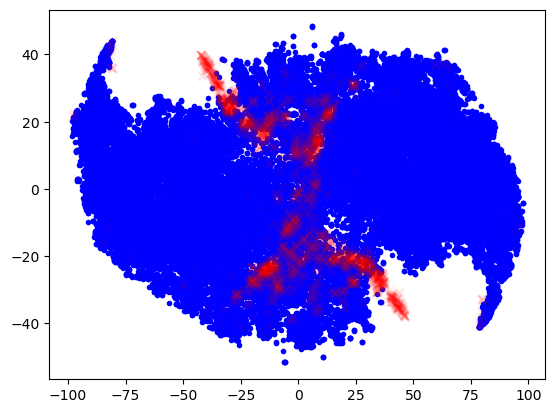

In [329]:
plt.figure()
plt.scatter(all_data_tsne[:N, 0], all_data_tsne[:N, 1], color='b', marker='.')
plt.scatter(all_data_tsne[N:, 0], all_data_tsne[N:, 1], color='r', marker='x', label='anomal', alpha=0.05)

plt.show()

### PCA

In [87]:
pca = PCA(2)
all_data_pca = pca.fit_transform(all_data)

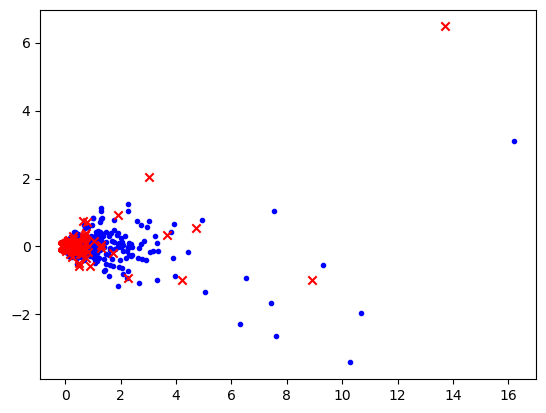

In [91]:
plt.figure()
plt.scatter(all_data_pca[:N, 0], all_data_pca[:N, 1], color='b', marker='.')
plt.scatter(all_data_pca[N:, 0], all_data_pca[N:, 1], color='r', marker='x', label='anomal')

plt.show()

### GaussianMixture

In [104]:
train, test = train_test_split(normal_data, test_size=anomal_data.shape[0])
test = np.concatenate([test, anomal_data])

In [283]:
def tsne_plots(data, shapes, params='', **tsne_kwargs):
    
    tsne = TSNE(n_components=2, **tsne_kwargs)
    data_tsne = tsne.fit_transform(data)
    
    train_N, test_normal_N, test_anomal_N = shapes
    plt.figure()
    plt.scatter(data_tsne[:train_N, 0], data_tsne[:train_N, 1], color='b', marker='.', label='train normal')
    plt.scatter(data_tsne[train_N:train_N + test_normal_N, 0], data_tsne[train_N:train_N + test_normal_N, 1], color='g', marker='1', label='test normal')

    plt.scatter(data_tsne[train_N + test_normal_N:, 0], data_tsne[train_N + test_normal_N:, 1], color='r', marker='x', label='test anomal', alpha=0.05)
    plt.legend()
    plt.title(f'tSNE({params}) of the whole dataset')
    plt.show()

In [123]:
gmm_data = np.concatenate([train, test])
gmm_data_tsne = TSNE(2).fit_transform(gmm_data)

train_N = train.shape[0]
test_normal_N = test_anomal_N = test.shape[0] // 2

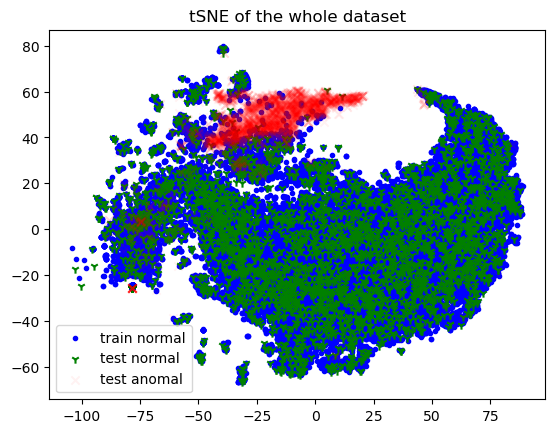

In [181]:
plt.figure()
plt.scatter(gmm_data_tsne[:train_N, 0], gmm_data_tsne[:train_N, 1], color='b', marker='.', label='train normal')
plt.scatter(gmm_data_tsne[train_N:train_N + test_normal_N, 0], gmm_data_tsne[train_N:train_N + test_normal_N, 1], color='g', marker='1', label='test normal')

plt.scatter(gmm_data_tsne[train_N + test_normal_N:, 0], gmm_data_tsne[train_N + test_normal_N:, 1], color='r', marker='x', label='test anomal', alpha=0.05)
plt.legend()
plt.title('tSNE of the whole dataset')
plt.show()

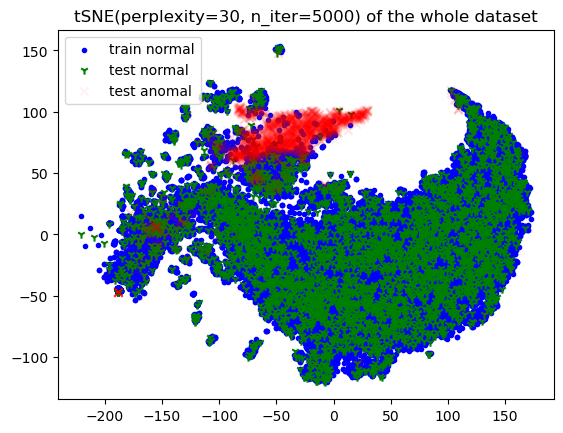

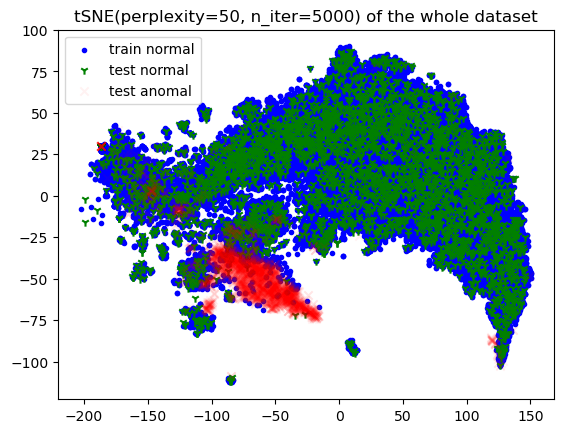

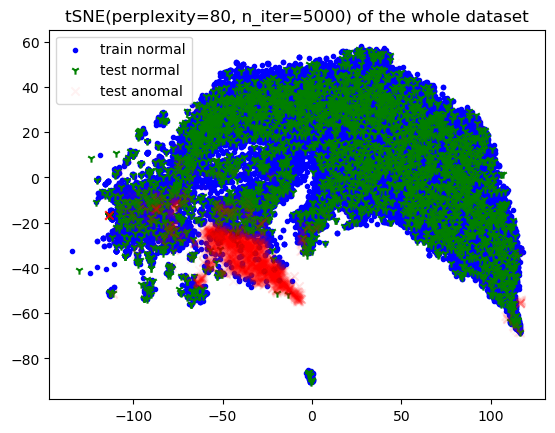

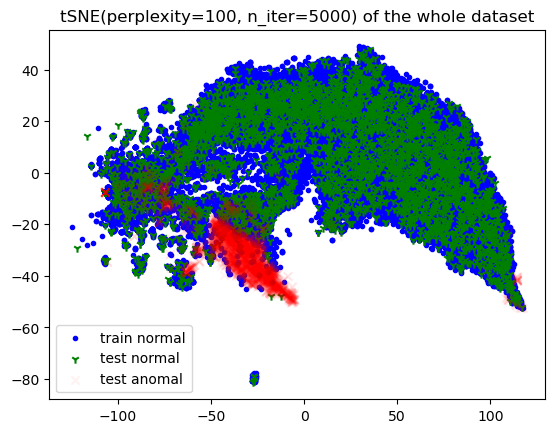

In [286]:
perplexities = [30, 50, 80, 100]
n_iter = 5000

for perplexity in perplexities:
    tsne_plots(gmm_data, shapes=(train_N, test_normal_N, test_anomal_N), params=f'perplexity={perplexity}, n_iter={n_iter}', perplexity=perplexity, n_iter=n_iter)


In [149]:
x, y = gmm_data_tsne[:, 0], gmm_data_tsne[:, 1]
labels = np.concatenate([np.zeros(train_N), np.ones(test_normal_N), 2 * np.ones(test_anomal_N)])

colors = ['b'] * train_N + ['g'] * test_normal_N + ['r'] * test_anomal_N
markers = ['.'] * train_N + ['1'] * test_normal_N + ['x'] * test_anomal_N



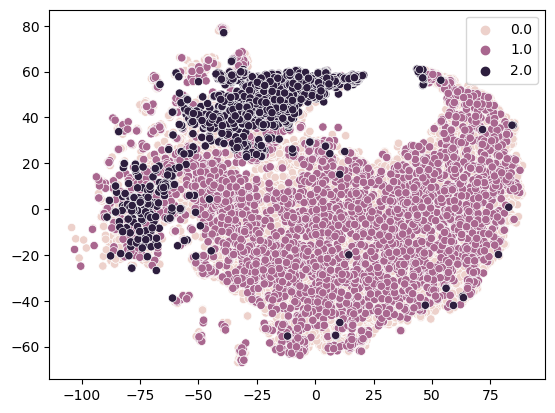

In [154]:
plt.figure()
sns.scatterplot(x=x, y=y, hue=labels, markers=labels)
plt.show()

In [156]:
gmm_kwargs = {
    'n_components': 1,
    'covariance_type': 'full'
}

gmm = GaussianMixture(**gmm_kwargs)

In [157]:
gmm.fit(train)

GaussianMixture()

In [251]:
test_scores = gmm.score_samples(test)

In [252]:
test_labels = np.concatenate([np.zeros(test_normal_N), np.ones(test_anomal_N)])

In [277]:
def plot_res(labels, scores, n_components=''):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc = roc_auc_score(labels, scores)
    
    t = np.linspace(0, 1, fpr.shape[0])
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot(t, t, 'r--', alpha=0.4)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC-AUC of GMM({n_components})')
    plt.text(x=0.7, y=0, s=f'AUC: {np.round(auc, 4)}', fontdict={'size': 15})
    plt.show()
        
        
def fit_and_test_gmm(train, test, labels, **gmm_kwargs):
    gmm = GaussianMixture(**gmm_kwargs)
    gmm.fit(train)
    test_scores = gmm.score_samples(test)
    plot_res(labels, test_scores, n_components=gmm_kwargs['n_components'])
    

In [259]:
fpr, tpr, thresholds = roc_curve(test_labels, test_scores)
auc = roc_auc_score(test_labels, test_scores)
auc

0.6393846165850005

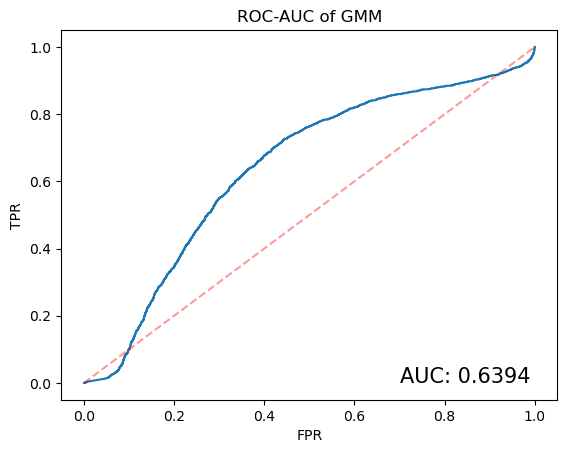

In [274]:
t = np.linspace(0, 1, fpr.shape[0])
plt.figure()
plt.plot(fpr, tpr)
plt.plot(t, t, 'r--', alpha=0.4)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-AUC of GMM')
plt.text(x=0.7, y=0, s=f'AUC: {np.round(auc, 4)}', fontdict={'size': 15})
plt.show()

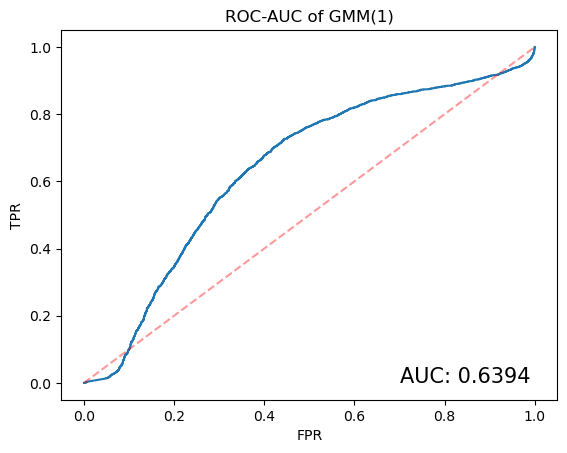

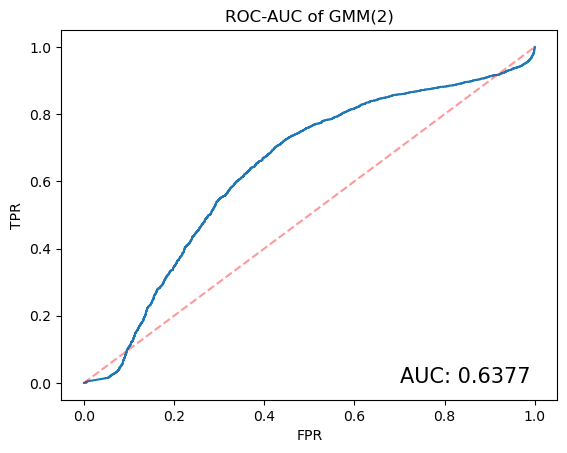

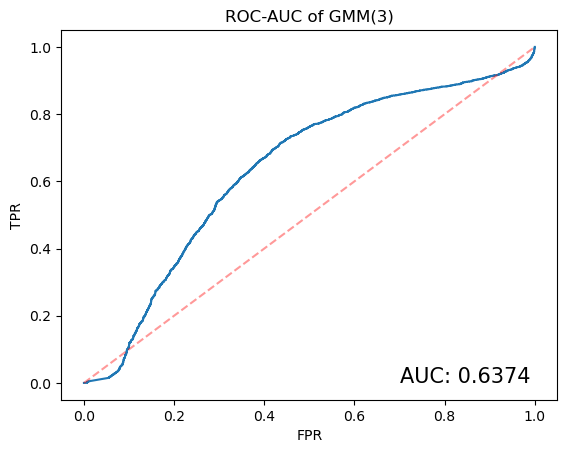

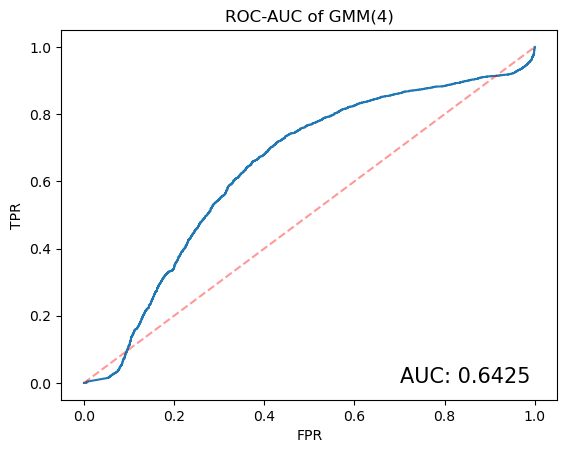

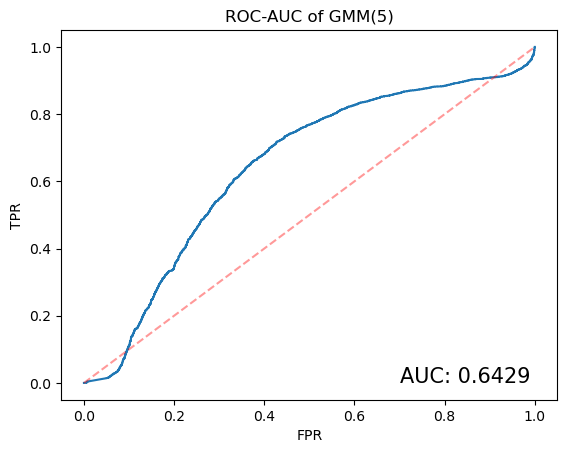

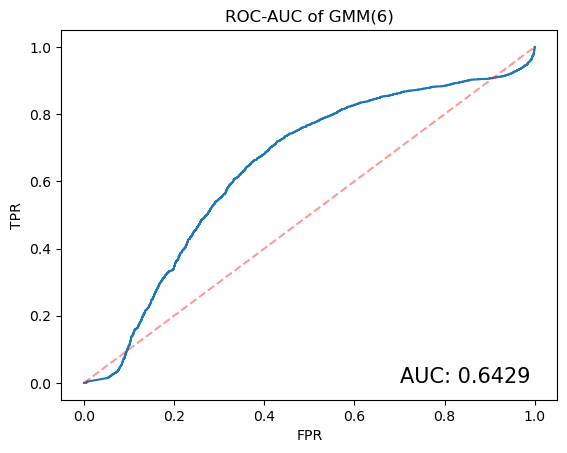

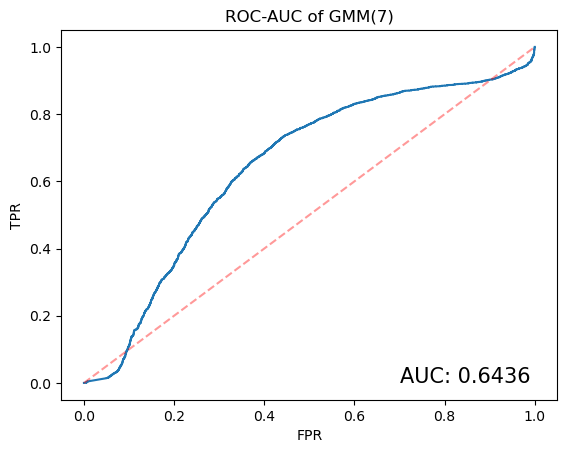

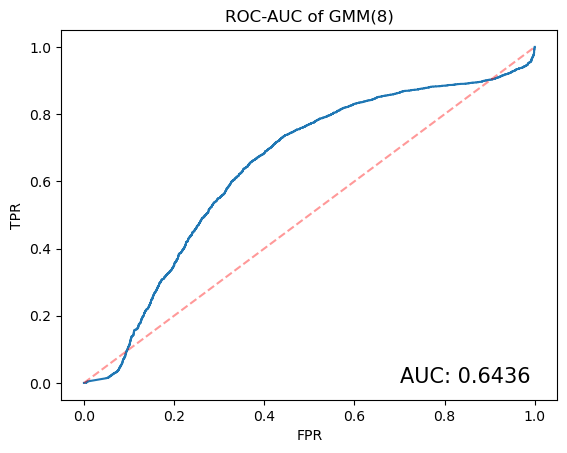

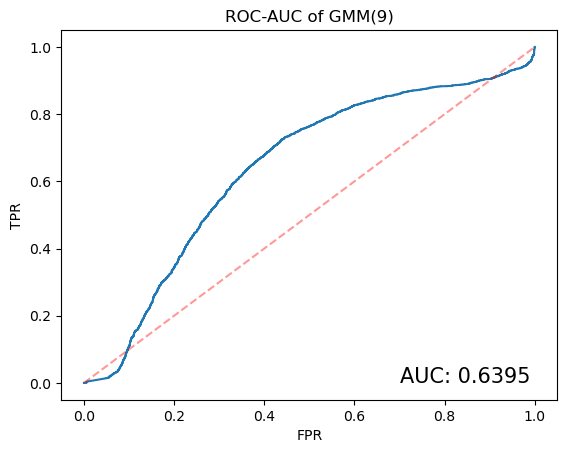

In [279]:
for n in range(1,10):
    fit_and_test_gmm(train, test, test_labels, n_components=n)

In [242]:
def normal_dist(X, mu, sigma):
    k = X.shape[1]
    scores = np.exp(-0.5 * (X - mu) @ np.linalg.inv(sigma) @ (X - mu).T) / np.sqrt(np.power(2 * np.pi, k) * np.linalg.det(sigma))
    return scores

In [209]:
mu = gmm.means_
sigma = gmm.covariances_.squeeze()

In [287]:
# s = normal_dist(test, gmm.means_, gmm.covariances_.squeeze())

(35121, 304)

In [300]:
train_pca = PCA(0.95).fit_transform(train)

In [303]:
train_pca_tsne = TSNE(2).fit_transform(train_pca)

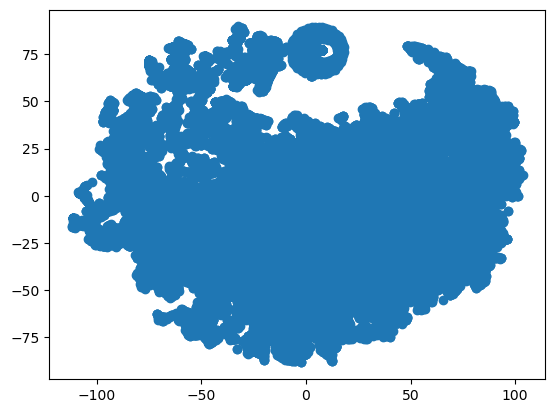

In [304]:

plt.figure()
plt.scatter(train_pca_tsne[:, 0], train_pca_tsne[:, 1])
plt.show()

(42281, 304)

In [325]:
pca3 = PCA(3)
train3d = pca3.fit_transform(all_data)
pca3.explained_variance_ratio_

array([0.81401705, 0.0623618 , 0.03125854])

In [314]:
# test3d = pca3.transform(test)

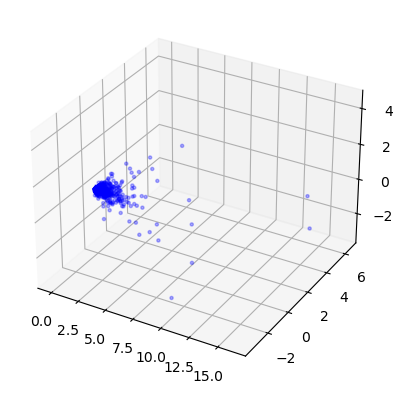

In [326]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(train3d[:, 0], train3d[:, 1], train3d[:, 2], color='b', marker='.', alpha=0.3)
# ax.scatter3D(test3d[:, 0], test3d[:, 1], test3d[:, 2], color='r', marker='x')

plt.show()